In [1]:
# 📌 Cell 1: Install PySpark (only needed in Colab)
!pip install pyspark

# 📌 Cell 2: Import Libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, to_date, to_timestamp
import matplotlib.pyplot as plt

# 📌 Cell 3: Initialize Spark
spark = SparkSession.builder \
    .appName("NYC Taxi Big Data Analysis") \
    .getOrCreate()


In [2]:
# 📌 Cell 4: Load Dataset
# Replace this with your file path
DATA_PATH = "/content/yellow-tripdata-2025-01.csv"  # Ensure this is uploaded
df = spark.read.csv(DATA_PATH, header=True, inferSchema=True)

df.printSchema()
df.show(5)


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: integer (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)

+--------+--------------------+---------------------+---------------+----

In [3]:
# 📌 Cell 5: Clean the Data
df_clean = df.dropna(subset=["passenger_count", "trip_distance", "fare_amount"])
df_clean = df_clean.filter(
    (df_clean.trip_distance > 0) &
    (df_clean.fare_amount > 0) &
    (df_clean.passenger_count > 0)
)

df_clean.show(5)


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:26:59|              1|          1.6|         1|                 N|         229|    

In [4]:
# 📌 Cell 6: Avg Trip Distance per Passenger Count
avg_distance = df_clean.groupBy("passenger_count") \
                       .avg("trip_distance") \
                       .orderBy("passenger_count")
avg_distance.show()


+---------------+------------------+
|passenger_count|avg(trip_distance)|
+---------------+------------------+
|              1| 3.236837682890384|
|              2| 4.136933045543559|
|              3| 4.142226378544467|
|              4| 4.492828621908151|
|              5| 3.153328137178488|
|              6| 3.406490026793687|
|              8|              0.04|
|              9|             20.08|
+---------------+------------------+



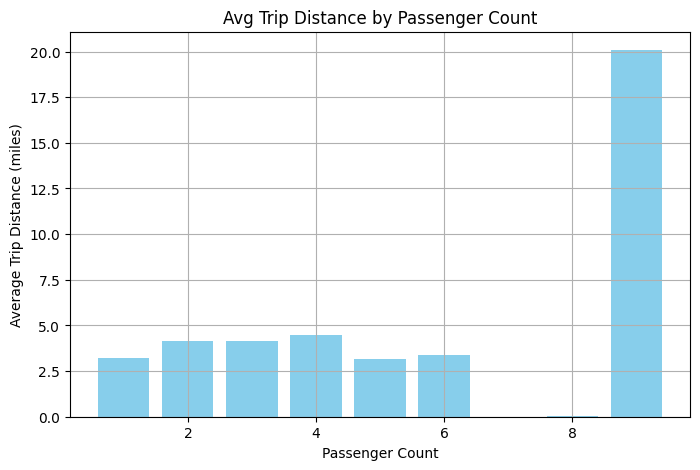

In [5]:
# 📌 Cell 7: Plot Avg Trip Distance
pdf = avg_distance.toPandas()

plt.figure(figsize=(8, 5))
plt.bar(pdf['passenger_count'], pdf['avg(trip_distance)'], color='skyblue')
plt.xlabel("Passenger Count")
plt.ylabel("Average Trip Distance (miles)")
plt.title("Avg Trip Distance by Passenger Count")
plt.grid(True)
plt.show()


In [6]:
# 📌 Cell 8: Trip Count by Hour
df_time = df_clean.withColumn("hour", hour(to_timestamp("tpep_pickup_datetime")))
hourly_count = df_time.groupBy("hour").count().orderBy("hour")
hourly_count.show()


+----+-----+
|hour|count|
+----+-----+
|   0|19229|
|   1|12961|
|   2| 9192|
|   3| 6320|
|   4| 4192|
|   5| 5198|
|   6|11337|
|   7|22567|
|   8|31298|
|   9|36229|
|  10|40431|
|  11|44261|
|  12|48080|
|  13|50601|
|  14|48758|
|  15|51496|
|  16|51841|
|  17|53269|
|  18|50593|
|  19|42348|
+----+-----+
only showing top 20 rows



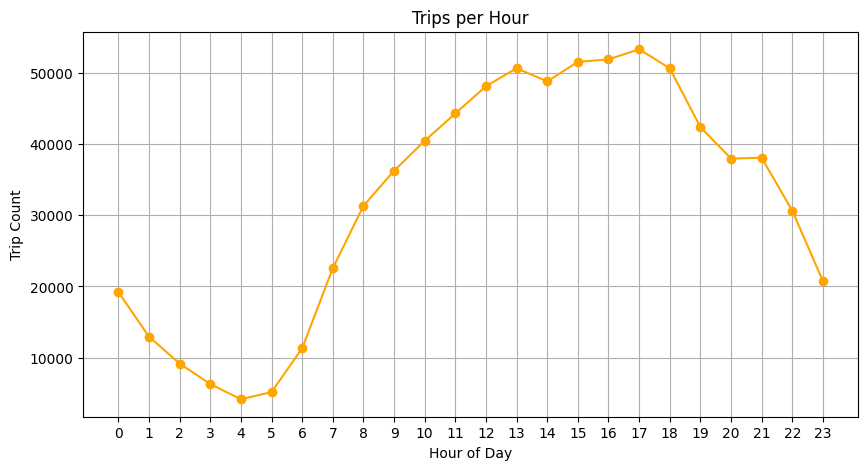

In [7]:
# 📌 Cell 9: Plot Hourly Trip Count
hour_pdf = hourly_count.toPandas()

plt.figure(figsize=(10, 5))
plt.plot(hour_pdf['hour'], hour_pdf['count'], marker='o', color='orange')
plt.xlabel("Hour of Day")
plt.ylabel("Trip Count")
plt.title("Trips per Hour")
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


In [8]:
# 📌 Cell 10: Total Revenue by Day
df_day = df_clean.withColumn("date", to_date("tpep_pickup_datetime"))
daily_revenue = df_day.groupBy("date").sum("fare_amount").orderBy("date")
daily_revenue.show()


+----------+------------------+
|      date|  sum(fare_amount)|
+----------+------------------+
|2024-12-31|401.59999999999997|
|2025-01-01|1461570.1900000132|
|2025-01-02|1583667.1900000041|
|2025-01-03|1599906.3800000057|
|2025-01-04| 1656019.410000031|
|2025-01-05| 1451815.420000012|
|2025-01-06|1395951.3900000073|
|2025-01-07|1559803.8700000278|
|2025-01-08| 1640261.290000014|
|2025-01-09| 658956.1000000029|
|2025-01-10|              54.2|
|2025-01-12|438455.95999999775|
|2025-01-13|1066624.9899999993|
+----------+------------------+



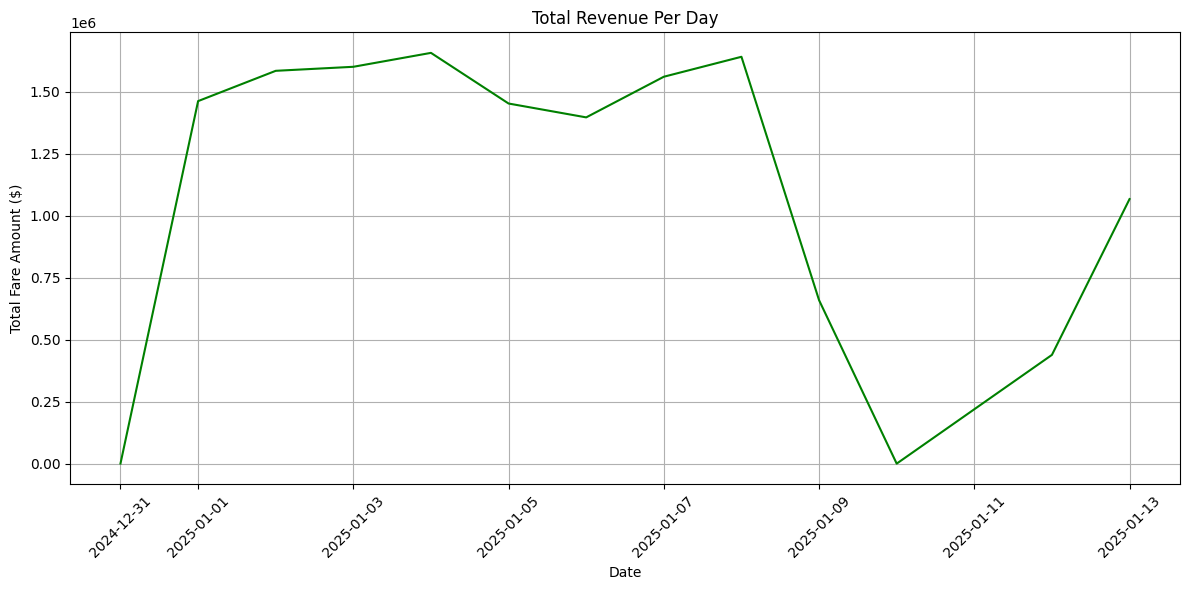

In [9]:
# 📌 Cell 11: Plot Daily Revenue
revenue_pdf = daily_revenue.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(revenue_pdf['date'], revenue_pdf['sum(fare_amount)'], color='green')
plt.xlabel("Date")
plt.ylabel("Total Fare Amount ($)")
plt.title("Total Revenue Per Day")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
